In [198]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Constants
image_dir = '/Users/sanvishukla/Desktop/pcos detection/data/images'  # Update this path
image_width = 128  # Adjust according to your image dimensions
image_height = 128
epochs = 10
batch_size = 32
validation_split = 0.2

# Function to load and preprocess image data
def load_and_preprocess_image(image_dir, image_width, image_height):
    X_images = []
    y_images = []
    
    infected_dir = os.path.join(image_dir, 'infected')
    notinfected_dir = os.path.join(image_dir, 'notinfected')
    
    # Load infected images
    for filename in os.listdir(infected_dir):
        img_path = os.path.join(infected_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (image_width, image_height))
            img = img.astype(np.float32) / 255.0  # Normalize image pixels to [0, 1]
            X_images.append(img)
            y_images.append(1.0)  # Label 1.0 for infected
    
    # Load non-infected images
    for filename in os.listdir(notinfected_dir):
        img_path = os.path.join(notinfected_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (image_width, image_height))
            img = img.astype(np.float32) / 255.0  # Normalize image pixels to [0, 1]
            X_images.append(img)
            y_images.append(0.0)  # Label 0.0 for not infected
    
    return np.array(X_images), np.array(y_images)

# Function to build the model
def build_model(input_shape_images):
    image_input = Input(shape=input_shape_images, name='image_input')

    # Image data branch
    image_branch = Conv2D(32, (3, 3), activation='relu')(image_input)
    image_branch = MaxPooling2D((2, 2))(image_branch)
    image_branch = Conv2D(64, (3, 3), activation='relu')(image_branch)
    image_branch = MaxPooling2D((2, 2))(image_branch)
    image_branch = Flatten()(image_branch)
    image_branch = Dense(64, activation='relu')(image_branch)

    output = Dense(1, activation='sigmoid')(image_branch)

    model = Model(inputs=image_input, outputs=output)
    
    return model
def train_model(model, X_images, y_images, epochs, batch_size, validation_split):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Add early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_images, y_images, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_split=validation_split,
                        callbacks=[early_stopping])
    
    return model, history

if __name__ == "__main__":
    # Load and preprocess image data
    X_images, y_images = load_and_preprocess_image(image_dir, image_width, image_height)
    
    # Split data into training and testing sets
    train_X_images, test_X_images, train_y_images, test_y_images = train_test_split(X_images, y_images, test_size=0.2, random_state=42)
    
    # Build the model
    model = build_model(train_X_images.shape[1:])
    
    # Train the model
    trained_model, history = train_model(model, train_X_images, train_y_images, epochs, batch_size, validation_split)
    
    # Save the trained model
    save_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model.save(os.path.join(save_path, 'pcos_detection_model.h5'))
    
    # Evaluate the model
    test_loss, test_accuracy = trained_model.evaluate(test_X_images, test_y_images)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")



Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.7919 - loss: 0.3923 - val_accuracy: 0.9968 - val_loss: 0.0185
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.9948 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 1.0000 - loss: 4.9098e-04 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 1.0000 - loss: 2.0742e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 1.0000 - loss: 1.0801e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 1.0000 - loss: 8.2121e-05 - val_accuracy: 1.0000 - val_loss: 7.8873e-04
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 1.0000 - loss: 6.23

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 2.1751e-04
Test Loss: 0.00029979937244206667
Test Accuracy: 1.0


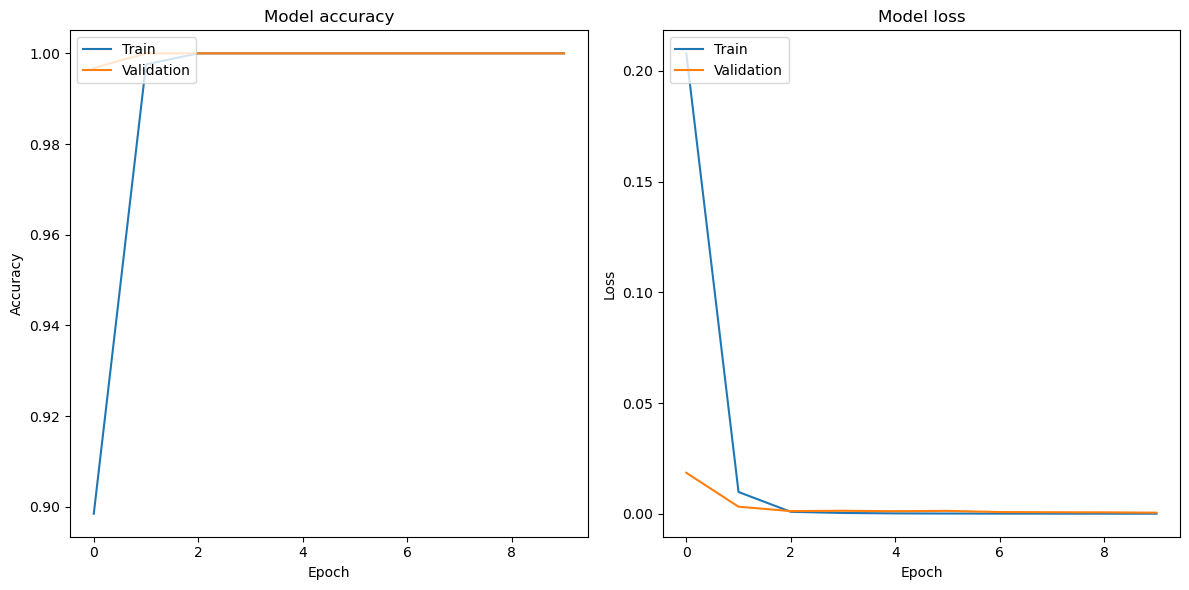

In [202]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Assuming 'history' variable contains the history object returned by model.fit()
plot_training_history(history)


In [204]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1

# Assuming 'trained_model' is your trained model and 'test_X_images', 'test_y_images' are your test data
# Predict on test data
y_pred = trained_model.predict(test_X_images)
y_pred_classes = (y_pred > 0.5).astype(np.int32)  # Convert probabilities to binary class labels

# Calculate evaluation metrics
accuracy, precision, recall, f1 = calculate_metrics(test_y_images, y_pred_classes)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Confusion matrix
conf_matrix = confusion_matrix(test_y_images, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:
[[226   0]
 [  0 159]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Constants
clinical_data_file = '/Users/sanvishukla/Desktop/pcos detection/data/clinical_data.csv'  # Path to the clinical data CSV file
epochs = 10
batch_size = 32
validation_split = 0.2

# Function to load clinical data
def load_clinical_data(file_path):
    clinical_data = pd.read_csv(file_path)
    
    # Strip leading and trailing spaces from column names
    clinical_data.columns = clinical_data.columns.str.strip()
    
    # Define required columns based on the provided header
    required_columns = ['Age (yrs)', 'Weight (Kg)', 'Height(Cm)', 'BMI', 
                        'Pulse rate(bpm)', 'Cycle length(days)', 'Pregnant(Y/N)', 
                        'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio', 'Weight gain(Y/N)', 
                        'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 
                        'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'PCOS (Y/N)']
    
    # Check which required columns are actually present in clinical_data
    existing_columns = [col for col in required_columns if col in clinical_data.columns]
    missing_columns = [col for col in required_columns if col not in clinical_data.columns]
    
    if missing_columns:
        print(f"Warning: Missing columns in clinical_data: {missing_columns}")
    
    X_clinical = clinical_data[existing_columns[:-1]].values.astype(np.float32)  # Exclude the target column
    y_clinical = clinical_data['PCOS (Y/N)'].values.astype(np.float32)  # Adjust this based on actual column name
    
    # Handling NaN and Infinite values
    X_clinical = np.nan_to_num(X_clinical, nan=0.0)  # Replace NaN with 0.0
    X_clinical = np.clip(X_clinical, a_min=-1e9, a_max=1e9)  # Clip extreme values
    
    return X_clinical, y_clinical

def build_model(input_shape_clinical):
    clinical_input = Input(shape=input_shape_clinical, name='clinical_input')
    clinical_branch = Dense(64, activation='relu')(clinical_input)
    clinical_branch = Dense(32, activation='relu')(clinical_branch)
    output = Dense(1, activation='sigmoid')(clinical_branch)
    model = Model(inputs=clinical_input, outputs=output)
    return model

# Function to train the model
def train_model(model, X_clinical, y_clinical, epochs, batch_size, validation_split):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Add early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_clinical, y_clinical, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_split=validation_split,
                        callbacks=[early_stopping])
    
    return history

if __name__ == "__main__":
    # Load clinical data
    X_clinical, y_clinical = load_clinical_data(clinical_data_file)
    
    # Normalize the clinical data
    scaler = StandardScaler()
    X_clinical = scaler.fit_transform(X_clinical)
    
    # Split data into training and testing sets
    train_X_clinical, test_X_clinical, train_y_clinical, test_y_clinical = train_test_split(X_clinical, y_clinical, test_size=0.2, random_state=42)
    
    # Build the model
    model = build_model(train_X_clinical.shape[1:])
    
    # Train the model
    history = train_model(model, train_X_clinical, train_y_clinical, epochs, batch_size, validation_split)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_X_clinical, test_y_clinical)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    
    # Save the trained model
    save_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model.save(os.path.join(save_path, 'clinical_data_model.h5'))
    # Save X_clinical to a numpy file
np.save('/Users/sanvishukla/Desktop/pcos detection/data/X_clinical.npy', X_clinical)
np.save('/Users/sanvishukla/Desktop/pcos detection/data/test_X_clinical.npy', test_X_clinical)
np.save('/Users/sanvishukla/Desktop/pcos detection/data/test_y_clinical.npy', test_y_clinical)



In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load clinical data
    X_clinical, y_clinical = load_clinical_data(clinical_data_file)
    
    # Normalize the clinical data
    scaler = StandardScaler()
    X_clinical = scaler.fit_transform(X_clinical)
    
    # Split data into training and testing sets
    train_X_clinical, test_X_clinical, train_y_clinical, test_y_clinical = train_test_split(X_clinical, y_clinical, test_size=0.2, random_state=42)
    
    # Build the model
    model = build_model(train_X_clinical.shape[1:])
    
    # Train the model
    history = train_model(model, train_X_clinical, train_y_clinical, epochs, batch_size, validation_split)
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_X_clinical, test_y_clinical)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    
    # Save the trained model
    save_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model.save(os.path.join(save_path, 'clinical_data_model.h5'))


In [296]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Constants
clinical_data_file = '/Users/sanvishukla/Desktop/pcos detection/data/clinical_data.csv'  # Path to the clinical data CSV file
saved_model_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models/clinical_data_model.h5'
epochs = 10
batch_size = 32
validation_split = 0.2

# Function to load clinical data
def load_clinical_data(file_path):
    clinical_data = pd.read_csv(file_path)
    
    # Strip leading and trailing spaces from column names
    clinical_data.columns = clinical_data.columns.str.strip()
    
    # Define required columns based on the provided header
    required_columns = ['Age (yrs)', 'Weight (Kg)', 'Height(Cm)', 'BMI', 
                        'Pulse rate(bpm)', 'Cycle length(days)', 'Pregnant(Y/N)', 
                        'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio', 'Weight gain(Y/N)', 
                        'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 
                        'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'PCOS (Y/N)']
    
    # Check which required columns are actually present in clinical_data
    existing_columns = [col for col in required_columns if col in clinical_data.columns]
    missing_columns = [col for col in required_columns if col not in clinical_data.columns]
    
    if missing_columns:
        print(f"Warning: Missing columns in clinical_data: {missing_columns}")
    
    X_clinical = clinical_data[existing_columns[:-1]].values.astype(np.float32)  # Exclude the target column
    y_clinical = clinical_data['PCOS (Y/N)'].values.astype(np.float32)  # Adjust this based on actual column name
    
    # Handling NaN and Infinite values
    X_clinical = np.nan_to_num(X_clinical, nan=0.0)  # Replace NaN with 0.0
    X_clinical = np.clip(X_clinical, a_min=-1e9, a_max=1e9)  # Clip extreme values
    
    return X_clinical, y_clinical

# Function to build the model
def build_model(input_shape_clinical):
    clinical_input = Input(shape=input_shape_clinical, name='clinical_input')

    # Clinical data branch
    clinical_branch = Dense(64, activation='relu')(clinical_input)
    clinical_branch = Dense(32, activation='relu')(clinical_branch)

    output = Dense(1, activation='sigmoid')(clinical_branch)

    model = Model(inputs=clinical_input, outputs=output)
    
    return model

# Function to train the model
def train_model(model, X_clinical, y_clinical, epochs, batch_size, validation_split):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Add early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_clinical, y_clinical, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_split=validation_split,
                        callbacks=[early_stopping])
    
    return history

# Function to evaluate model metrics
def evaluate_model(model, X_test, y_test):
    # Predict probabilities
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(np.int32)  # Convert probabilities to binary class labels
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate precision, recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

if __name__ == "__main__":
    # Load clinical data
    X_clinical, y_clinical = load_clinical_data(clinical_data_file)
    
    # Normalize the clinical data
    scaler = StandardScaler()
    X_clinical = scaler.fit_transform(X_clinical)
    
    # Split data into training and testing sets
    train_X_clinical, test_X_clinical, train_y_clinical, test_y_clinical = train_test_split(X_clinical, y_clinical, test_size=0.2, random_state=42)
    
    # Build the model
    model = build_model(train_X_clinical.shape[1:])
    
    # Train the model
    history = train_model(model, train_X_clinical, train_y_clinical, epochs, batch_size, validation_split)
    
    # Evaluate the model on test data
    print("Evaluation on Test Data:")
    evaluate_model(model, test_X_clinical, test_y_clinical)
    
    # Save the trained model
    save_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model.save(os.path.join(save_path, 'clinical_data_model.h5'))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7102 - loss: 0.6136 - val_accuracy: 0.7701 - val_loss: 0.5417
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7484 - loss: 0.5394 - val_accuracy: 0.7931 - val_loss: 0.4978
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8294 - loss: 0.4869 - val_accuracy: 0.7931 - val_loss: 0.4663
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8570 - loss: 0.4441 - val_accuracy: 0.8161 - val_loss: 0.4409
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8481 - loss: 0.4025 - val_accuracy: 0.8391 - val_loss: 0.4228
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8359 - loss: 0.4196 - val_accuracy: 0.8391 - val_loss: 0.4094
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8627 - loss: 0.3797 - val_accuracy: 0.8391 - val_loss: 0.4019
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8627 - loss: 0.3657 - val_accuracy: 0.8391 - val_loss

Accuracy: 0.8716
Precision: 0.8214
Recall: 0.7188
F1-score: 0.7667
Confusion Matrix:
[[72  5]
 [ 9 23]]


In [300]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models/pcos_detection_model.h5'

# Load the trained model
model = load_model(model_path)
def predict_pcos(image_path, model, target_size=(128, 128)):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)  # Resize to target size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    
    # Interpret prediction
    if prediction[0, 0] > 0.5:
        return "You are predicted to have signs of PCOS."
    else:
        return "You are predicted to not have signs of PCOS."
# Example usage:
image_path = '/Users/sanvishukla/Desktop/pcos detection/data/images/infected/img_0_93.jpg'  # Replace with your image path
prediction = predict_pcos(image_path, model)

# Print prediction
print(prediction)
import matplotlib.pyplot as plt

# Load and display the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(img)
plt.axis('off')
plt.title(prediction)
plt.show()


[ WARN:0@19661.917] global loadsave.cpp:241 findDecoder imread_('/Users/sanvishukla/Desktop/pcos detection/data/images/infected/img_0_93.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [287]:
from tensorflow.keras.models import load_model

# Load the trained model
model_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models/clinical_data_model.h5'
model = load_model(model_path)
import numpy as np

def get_input():
    # Ask user for input values
    print("Please enter the following clinical data points:")
    age = float(input("Age (in years): "))
    weight = float(input("Weight (in Kg): "))
    height = float(input("Height (in cm): "))
    bmi = float(input("BMI: "))
    pulse_rate = float(input("Pulse rate (in bpm): "))
    cycle_length = float(input("Cycle length (in days): "))
    pregnant = float(input("Pregnant (Y=1, N=0): "))
    hip = float(input("Hip circumference (in inches): "))
    waist = float(input("Waist circumference (in inches): "))
    waist_hip_ratio = float(input("Waist to Hip Ratio: "))
    weight_gain = float(input("Weight gain (Y=1, N=0): "))
    hair_growth = float(input("Excessive hair growth (Y=1, N=0): "))
    skin_darkening = float(input("Skin darkening (Y=1, N=0): "))
    hair_loss = float(input("Hair loss (Y=1, N=0): "))
    pimples = float(input("Pimples (Y=1, N=0): "))
    fast_food = float(input("Fast food consumption (Y=1, N=0): "))
    reg_exercise = float(input("Regular exercise (Y=1, N=0): "))
    
    # Create input array
    input_data = np.array([[age, weight, height, bmi, pulse_rate, cycle_length, pregnant,
                            hip, waist, waist_hip_ratio, weight_gain, hair_growth,
                            skin_darkening, hair_loss, pimples, fast_food, reg_exercise]], dtype=np.float32)
    
    return input_data

# Get user input
input_data = get_input()

# Scale input data using the same scaler used during training
scaled_input_data = scaler.transform(input_data)

# Predict PCOS status
prediction = model.predict(scaled_input_data)

# Interpret prediction
if prediction[0, 0] >= 0.5:
    print("Prediction: You are likely to have PCOS.")
else:
    print("Prediction: You are not likely to have PCOS.")
# Evaluate accuracy on test data
test_loss, test_accuracy = model.evaluate(test_X_clinical, test_y_clinical)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Please enter the following clinical data points:


Age (in years):  36
Weight (in Kg):  65
Height (in cm):  161.5
BMI:  24.92116286
Pulse rate (in bpm):  74
Cycle length (in days):  5
Pregnant (Y=1, N=0):  1
Hip circumference (in inches):  38
Waist circumference (in inches):  32
Waist to Hip Ratio:  0.8421052632
Weight gain (Y=1, N=0):  0
Excessive hair growth (Y=1, N=0):  0
Skin darkening (Y=1, N=0):  0
Hair loss (Y=1, N=0):  0
Pimples (Y=1, N=0):  0
Fast food consumption (Y=1, N=0):  0
Regular exercise (Y=1, N=0):  0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: You are not likely to have PCOS.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.8527 - loss: 0.3984
Test Loss: 0.37762704491615295
Test Accuracy: 85.32%


In [289]:
from tensorflow.keras.models import load_model

# Load the trained model
model_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models/clinical_data_model.h5'
model = load_model(model_path)
import numpy as np

def get_input():
    # Ask user for input values
    print("Please enter the following clinical data points:")
    age = float(input("Age (in years): "))
    weight = float(input("Weight (in Kg): "))
    height = float(input("Height (in cm): "))
    bmi = float(input("BMI: "))
    pulse_rate = float(input("Pulse rate (in bpm): "))
    cycle_length = float(input("Cycle length (in days): "))
    pregnant = float(input("Pregnant (Y=1, N=0): "))
    hip = float(input("Hip circumference (in inches): "))
    waist = float(input("Waist circumference (in inches): "))
    waist_hip_ratio = float(input("Waist to Hip Ratio: "))
    weight_gain = float(input("Weight gain (Y=1, N=0): "))
    hair_growth = float(input("Excessive hair growth (Y=1, N=0): "))
    skin_darkening = float(input("Skin darkening (Y=1, N=0): "))
    hair_loss = float(input("Hair loss (Y=1, N=0): "))
    pimples = float(input("Pimples (Y=1, N=0): "))
    fast_food = float(input("Fast food consumption (Y=1, N=0): "))
    reg_exercise = float(input("Regular exercise (Y=1, N=0): "))
    
    # Create input array
    input_data = np.array([[age, weight, height, bmi, pulse_rate, cycle_length, pregnant,
                            hip, waist, waist_hip_ratio, weight_gain, hair_growth,
                            skin_darkening, hair_loss, pimples, fast_food, reg_exercise]], dtype=np.float32)
    
    return input_data

# Get user input
input_data = get_input()

# Scale input data using the same scaler used during training
scaled_input_data = scaler.transform(input_data)

# Predict PCOS status
prediction = model.predict(scaled_input_data)

# Interpret prediction
if prediction[0, 0] >= 0.5:
    print("Prediction: You are likely to have PCOS.")
else:
    print("Prediction: You are not likely to have PCOS.")
# Evaluate accuracy on test data
test_loss, test_accuracy = model.evaluate(test_X_clinical, test_y_clinical)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Please enter the following clinical data points:


Age (in years):  33
Weight (in Kg):  68.8
Height (in cm):  165
BMI:  25.27089073
Pulse rate (in bpm):  72
Cycle length (in days):  5
Pregnant (Y=1, N=0):  1
Hip circumference (in inches):  40
Waist circumference (in inches):  36
Waist to Hip Ratio:  .9
Weight gain (Y=1, N=0):  0
Excessive hair growth (Y=1, N=0):  0
Skin darkening (Y=1, N=0):  0
Hair loss (Y=1, N=0):  1
Pimples (Y=1, N=0):  1
Fast food consumption (Y=1, N=0):  1
Regular exercise (Y=1, N=0):  0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: You are not likely to have PCOS.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.8527 - loss: 0.3984
Test Loss: 0.37762704491615295
Test Accuracy: 85.32%
